In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [6]:
sales = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\new_sales_csv.csv")
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_type_new
0,FDA15,weights2,Low Fat,low,Dairy,249.8092,OUT049,med,High,Tier 1,Supermarket Type1,3735.1380,other
1,DRC01,weights1,Regular,low,Soft Drinks,48.2692,OUT018,low,High,Tier 2,Supermarket Type2,443.4228,Drinks
2,FDN15,weights1,Low Fat,low,Meat,141.6180,OUT049,med,High,Tier 1,Supermarket Type1,2097.2700,other
3,FDX07,weights1,Regular,low,Fruits and Vegetables,182.0950,OUT010,med,High,Tier 2,Grocery Store,732.3800,other
4,NCD19,weights1,Low Fat,low,Household,53.8614,OUT013,med,High,Tier 2,Supermarket Type1,994.7052,other


In [7]:
#deleting unwanted features 
#also deleted Item_Fat_Content because from hypothesis testing,we found that there is no difference in the means.
sales = sales.drop(['Item_Identifier','Item_Type','Outlet_Identifier','Item_Fat_Content'], axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

encoder_list = ['Item_Weight', 'Item_Visibility',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 
       'Item_type_new']

for i in encoder_list:
    sales[i] = le.fit_transform(sales[i])

In [9]:
sales = pd.get_dummies(sales, columns=encoder_list)

In [10]:
#avoiding dummy variable trap
sales = sales.drop(['Item_Weight_0','Item_Visibility_0','Outlet_Establishment_Year_0','Outlet_Size_0',
                   'Outlet_Location_Type_0','Outlet_Type_0','Item_type_new_0'], axis=1)

In [11]:
X = sales.drop(['Item_Outlet_Sales'], axis=1)
y = sales.Item_Outlet_Sales

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sc = StandardScaler()
XX = sc.fit_transform(X)

#### Test dataset

In [13]:
test = pd.read_csv("C:\\Users\\DHRUBAJIT\\Desktop\\AnalyticsVidhya\\Big Mart Sales\\new_testsales_csv.csv")

item_id = test['Item_Identifier']
out_id = test['Outlet_Identifier']

test = test.drop(['Item_Identifier','Item_Type','Outlet_Identifier','Item_Fat_Content'], axis=1)

for i in encoder_list:
    test[i] = le.fit_transform(test[i])
    
test = pd.get_dummies(test, columns=encoder_list)

test = test.drop(['Item_Weight_0','Item_Visibility_0','Outlet_Establishment_Year_0','Outlet_Size_0',
                   'Outlet_Location_Type_0','Outlet_Type_0','Item_type_new_0'], axis=1)

test = sc.fit_transform(test)

### Model Selection

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def validation_cross(model, x,y):
    model.fit(x, y)

    #Predict training set:
    pred = model.predict(x)

    #Perform cross-validation:
    cv_score = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))

    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(mean_squared_error(y.values, pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g" % (np.mean(cv_score),np.std(cv_score)))
    

from sklearn.model_selection import learning_curve
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.cross_validation import KFold

def plot_curve(model, train, title):
    model.fit(train, y)
    train_sizes, train_scores, test_scores = learning_curve(model, train, y, n_jobs=-1, cv=5, train_sizes=np.linspace(.1, 1., 10), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

#### 1. LinearRegression

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
validation_cross(lr, XX, y)


Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 16.77


#### 2. KNeighborsRegressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
validation_cross(knn, XX, y)


Model Report
RMSE : 957.9
CV Score : Mean - 1175 | Std - 40.23


#### 3. DecisionTreeRegressor

In [15]:
from sklearn.tree import DecisionTreeRegressor
dc = DecisionTreeRegressor()
validation_cross(dc, XX, y)


Model Report
RMSE : 146.8
CV Score : Mean - 1560 | Std - 46.4


#### 4. RandomForestRegressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
validation_cross(rf, XX, y)


Model Report
RMSE : 537.1
CV Score : Mean - 1271 | Std - 34.83


#### 5. GradientBoostingRegressor

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
validation_cross(gbr, XX, y)


Model Report
RMSE : 1048
CV Score : Mean - 1090 | Std - 19.69


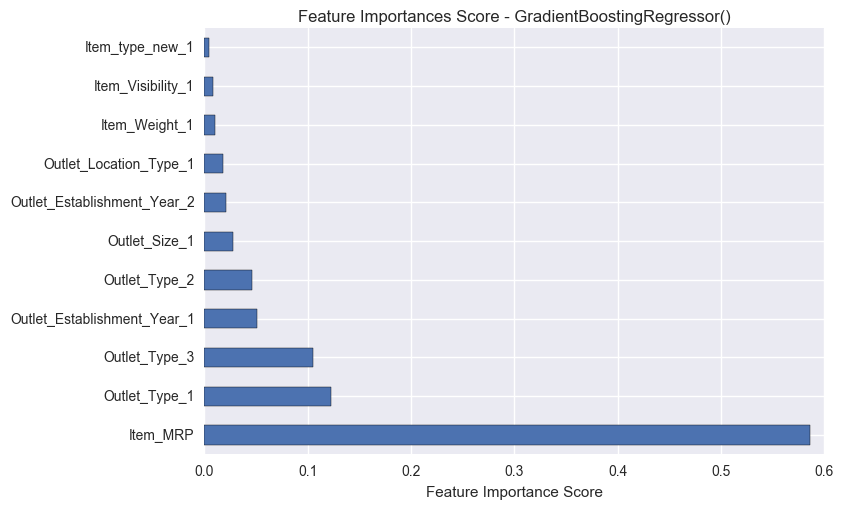

In [35]:
predictors = ['Item_MRP', 'Item_Weight_1', 'Item_Visibility_1',
       'Outlet_Establishment_Year_1', 'Outlet_Establishment_Year_2',
       'Outlet_Size_1', 'Outlet_Location_Type_1', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3', 'Item_type_new_1']
feat_imp = pd.Series(gbr.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances Score - GradientBoostingRegressor()')
plt.xlabel('Feature Importance Score')
plt.savefig("feat_imp.png")

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


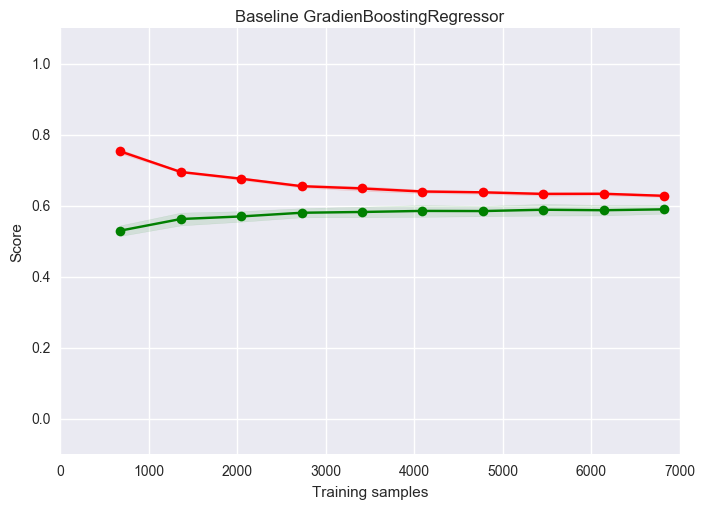

In [17]:
plot_curve(gbr, XX, "Baseline GradientBoostingRegressor")

#### 6. SVR 

In [21]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
validation_cross(svr, XX, y)


Model Report
RMSE : 1199
CV Score : Mean - 1208 | Std - 31.42


#### 7. SGDRegressor

In [23]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
validation_cross(sgd, XX, y)

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



Model Report
RMSE : 1129
CV Score : Mean - 1131 | Std - 15.78


### Feature Selection

### With GradientBoostingRegressor

#### 1. Recursive feature elimination (RFE)

In [25]:
from sklearn.feature_selection import RFE

rfe = RFE(gbr)
rfe.fit(XX,y)
print("Original number of features : %d" %XX.shape[1])

data_transformed_rfe = sales.iloc[:, rfe.get_support()]
print("Selected number of features : %d" %data_transformed_rfe.shape[1])

Original number of features : 11
Selected number of features : 5


In [26]:
validation_cross(gbr, data_transformed_rfe, y)


Model Report
RMSE : 1261
CV Score : Mean - 1299 | Std - 21.74


#### 2. PCA

In [28]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
data_transformed_pca = pca.fit_transform(XX)

print("Original number of features : %d" %XX.shape[1])
print("Selected number of features : %d" %data_transformed_pca.shape[1])

Original number of features : 11
Selected number of features : 8


In [29]:
validation_cross(gbr, data_transformed_pca, y)


Model Report
RMSE : 1042
CV Score : Mean - 1093 | Std - 27.16


#### 3. L2-based

In [19]:
from sklearn.linear_model import SGDRegressor

from sklearn.feature_selection import SelectFromModel

lsvc = SGDRegressor(penalty="l2").fit(XX, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(XX)
print("Original number of features : %d" %XX.shape[1])
print("Selected number of features : %d" %X_new.shape[1])

Original number of features : 11
Selected number of features : 4


C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [20]:
validation_cross(gbr, X_new, y)


Model Report
RMSE : 1052
CV Score : Mean - 1092 | Std - 21.35


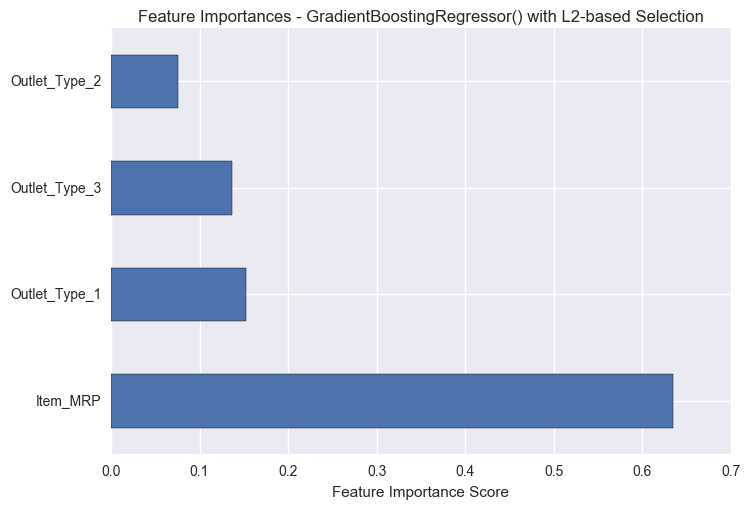

In [53]:
predictors = ['Item_MRP', 'Outlet_Type_1',
       'Outlet_Type_2', 'Outlet_Type_3']
feat_imp = pd.Series(gbr.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances - GradientBoostingRegressor() with L2-based Selection')
plt.xlabel('Feature Importance Score')
plt.savefig("feat_imp.png")

C:\Users\DHRUBAJIT\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


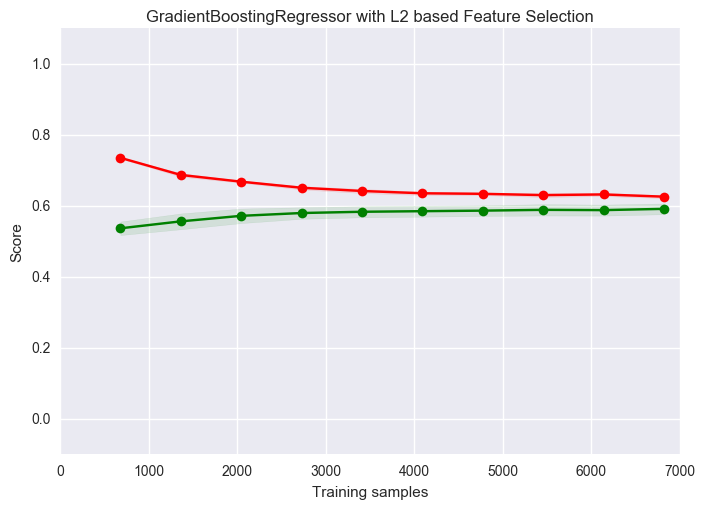

In [23]:
plot_curve(gbr, X_new, "GradientBoostingRegressor with L2 based Feature Selection")

### With SGDRegressor

#### 1. RFE

In [35]:
rfe1 = RFE(sgd)
rfe1.fit(XX,y)
print("Original number of features : %d" %XX.shape[1])

data_transformed_rfe1 = sales.iloc[:, rfe1.get_support()]
print("Selected number of features : %d" %data_transformed_rfe1.shape[1])

Original number of features : 11
Selected number of features : 5


In [36]:
validation_cross(sgd, data_transformed_rfe1, y)


Model Report
RMSE : 1.069e+12
CV Score : Mean - 1.033e+13 | Std - 7.584e+12


#### 2. PCA

In [37]:
validation_cross(sgd, data_transformed_pca, y)


Model Report
RMSE : 1307
CV Score : Mean - 1308 | Std - 27.58


#### 3. L2-based

In [46]:
validation_cross(sgd, X_new, y)


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 18.24
